# Getting Started with ``spore``

``spore`` is a set of modules/classes/functions to self-consistently create low-frequency radio interferometric EoR foreground models and analyse them in different ways.
It centres around 3 basic tasks, each implemented as its own sub-package, which can interact to some degree: 
1. ``model``: define individual foreground model components analytically, and combine them analytically.
2. ``mock``: combine different ``model``s to produce a sampled realisation of the sky.
3. ``measure``: given a realisation of the sky (either a result from a ``mock`` or from some external simulation), make measurements of the power spectrum on it.

``spore`` also contains a sub-package dedicated to visualising these results.

In this notebook we'll show some simple examples of how to use the above three sub-packages, focusing on creating ``model``s. First, we'll do a few imports to set us up.

In [1]:
import numpy as np
from spore.mock.foregrounds import PointSourceForegrounds, PointSourceForegroundsDirect

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Model

At this time, ``spore`` defines 4 kinds of models (we'll call them component models): beam models, source counts, spatial distributions, and spectral index distributions. They are imported as follows:

In [2]:
from spore.model import beam, source_counts, spatial_dist, spectral_index

Each module comprises a base component class, along with some number of specific models for that component. The idea behind this layout is that you can define your own specific models for that component in your own code, by subclassing the base component class and following its API. Let's have a brief look at each component.

### Beam Models

The base component class for beam models is ``Beam``. It's input API is such that 1 necessary parameter is present: ``nu0`` which defines the reference frequency for the beam parameters.

The main output API that the subclass must implement is ``beam``, which takes a vector of ``l`` (and optionally ``m``) and evaluates beam attenuation at those co-ordinates, at frequency ``f0`` which defines the frequency (as a ratio to ``nu0``) at which the beam quantities are to be evaluated. This latter can be an array. If so, the returned array has an extra dimension (which can get quite large very quickly).

The obvious simple model is a Circular Gaussian beam, and this is implemented within the class. To call it, use

In [3]:
gaussbeam = beam.CircularGaussian(nu0=150., D=4.) #Note D is the diameter of the array tile.

One can evaluate attenuation at any co-ordinate:

In [4]:
gaussbeam.beam(np.array([0]))

<Quantity [[ 1.]]>

In [5]:
gaussbeam.beam(np.array([0]), np.array([0.2]))

<Quantity [[ 0.634992]]>

In [6]:
gaussbeam.beam(np.linspace(0,1,10), f0=np.array([1,1.5]))

<Quantity [[  1.00000000e+00,  8.69212582e-01,  5.70826355e-01,
              2.83226599e-01,  1.06173483e-01,  3.00711545e-02,
              6.43481620e-03,  1.04033737e-03,  1.27076212e-04,
              1.17275240e-05],
           [  1.00000000e+00,  7.29513796e-01,  2.83226599e-01,
              5.85196315e-02,  6.43481620e-03,  3.76563073e-04,
              1.17275240e-05,  1.94375691e-07,  1.71452802e-09,
              8.04848693e-12]]>

### Source Counts Models

The base component class for source counts is ``SourceCounts``. To it, one must pass ``Smin0`` (the faintest sources at ``nu0``), ``Smax0`` (the brightest sources at ``nu0``), ``f0`` and ``spectral_index``. Along with these, each subclass will define its own set of additional parameters. The simplest example is a power-law:

In [7]:
pl_source_counts = source_counts.PowerLawSourceCounts(Smin0=1e-2, Smax0=1.0, f0=1.0, # Default for spectral_index is 0.8
                                                      alpha=6998.,  # Normalisation of powr=er-law
                                                      beta =1.54   # Slope of power-law
                                                     )

One can evaluate a few simple quantities:

In [8]:
print(pl_source_counts.total_number_density)
print(pl_source_counts.total_flux_density)
print(pl_source_counts.total_squared_flux_density)

142845.305805 1 / sr
13384.0333666 Jy / sr
4787.38805033 Jy2 / sr


One can evaluate the actual source counts at any flux density (at $\nu_0$):

In [9]:
pl_source_counts.dnds(0.5)

<Quantity 20349.799352415066 1 / (Jy sr)>

In addition, one can evaluate any moment of the source counts (defined as $\mu_n = \int S^n \frac{dN}{dS} dS$):

In [10]:
pl_source_counts.mu(1)

<Quantity 13384.033366640728 Jy / sr>

Finally, one can sample the source counts (at $\nu_0$):

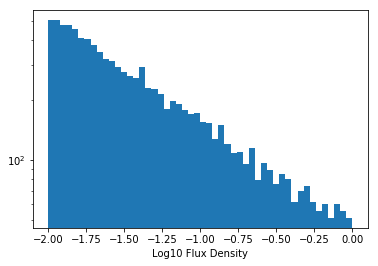

In [11]:
fluxes = pl_source_counts.sample_source_counts(10000)

plt.hist(np.log10(fluxes.value),bins=50)
plt.yscale('log')
plt.xlabel("Log10 Flux Density")

### Spectral Index

At this point, there are only a couple of spectral index distribution models. Note that these all assume that a source has a power-law SED within the bandwidth of interest. Perhaps later versions will generalise to more complicated SED's. The most common/easy spectral index distribution is the universal one (i.e. every source has the same spectral index):

In [12]:
spec_index_dist = spectral_index.UniversalDist(0.8)

This object has a method to sample this distribution:

In [13]:
spec_index_dist.sample(n=10)

array([ 0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8,  0.8])

### Spatial Distributions

There are two fundamentally different kinds of spatial distribution -- those that have shot noise from the discreteness of sources, and those that do not. All of these are contained in the ``spatial_dist`` module, and are subclassed from the ``SpatialDistribution`` base component class.

We'll use an example of both here:

In [13]:
pure_sky = spatial_dist.PureClustering_FlatSky(f0 = 1., # Frequencies (as ratios to ref. freq.) to evaluate sky at.
                                               sky_size = 2.0,             # Size of sky in l,m co-ordinates
                                               ncells = 256,              # Number of grid cells along a side 
                                               seed = 1234,                # Optional seed to enforce the same realisation on every run
                                               power_spectrum = lambda u : (u/0.1)**-2.0   # A function defining an isotropic power spectrum of sources as a function of scale u.
                                              )

# Define poisson sky with all the same parameters
poisson_sky = spatial_dist.PoissonClustering_FlatSky(
                                               f0 = 1.,
                                               sky_size = 2.0,             
                                               ncells = 256,              
                                               seed = 1234,                
                                               power_spectrum = lambda u : (u/0.1)**-2.0
                                              )


To create a uniformly distributed sky, one just needs to not pass the ``power_spectrum`` argument

The most relevant method of these classes is ``sky``. It gives a grid of sky brightnesses, at all frequencies. One thing to keep in mind is the "pure" clustering classes have a different signature for this method. They require only a mean brightness (for all frequencies), whereas "poisson" classes require an array of source positions, fluxes and spectral indices. We'll show both here:

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in power
/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in power


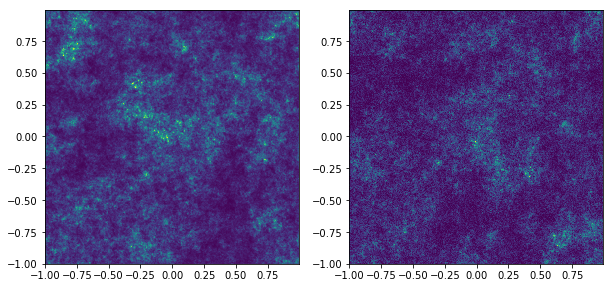

In [15]:
fig, ax = plt.subplots(1,2, figsize=(10,7))

# The pure clustering sky call.
puresky = pure_sky.sky(sbar=[10.])

# For poisson clustering, need a sample of positions. Poisson classes have a method to do this:
source_pos = poisson_sky.source_positions(nbar=100000.)
npos = len(source_pos[0])
fluxes = np.random.uniform(size=npos)
specs = 0.8 * np.ones(npos)

poissonsky = poisson_sky.sky(source_pos, fluxes, specs)

# Plot it up
ax[0].imshow(puresky[0,:,:].T, extent=(pure_sky.lgrid[0].min().value,pure_sky.lgrid[0].max().value,pure_sky.lgrid[0].min().value,pure_sky.lgrid[0].max().value), origin='lower')
ax[1].imshow(poissonsky[0,:,:].T, extent=(pure_sky.lgrid[0].min().value,pure_sky.lgrid[0].max().value,pure_sky.lgrid[0].min().value,pure_sky.lgrid[0].max().value), origin='lower')

Of course, we can also plot say a scatter-plot of the source positions themselves:

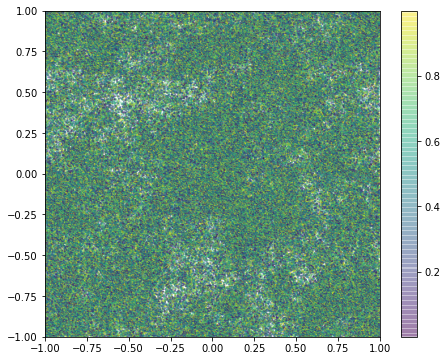

In [16]:
plt.figure(figsize=(7.5,6))
plt.scatter(source_pos[0], source_pos[1], s=1, c=fluxes, alpha = 0.3)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.colorbar()

From v0.0.3, there are also built-in classes for populating the sky treating solid-angles as equal, rather than $l,m$-coordinates. We'll show an example of this in the next section, but show here how to create them:

In [14]:
poisson_sky_sph = spatial_dist.PoissonClustering_Spherical(
                                               f0 = 1.,
                                               sky_size = 2.0,             
                                               ncells = 256,              
                                               seed = 1234,                
                                               power_spectrum = lambda l : (l/0.3)**-2.0,
                                               nside = 64,  # Resolution of underlying spherical HEALpix grid
                                               lmax = 1000  # Resolution of power spectrum itself
                                              )

pure_sky_sph = spatial_dist.PureClustering_Spherical(
                                               f0 = 1.,
                                               sky_size = 2.0,             
                                               ncells = 256,              
                                               seed = 1234,                
                                               power_spectrum = lambda l : (l/0.3)**-2.0,
                                               nside = 64,  # Resolution of underlying spherical HEALpix grid
                                               lmax = 1000  # Resolution of power spectrum itself
                                              )


## Mock

In this section, we put the models of the first section together to create a self-consistent mock. The way to do this should seem reasonably obvious by inspecting the spatial distribution setup, however, we wrap all of this in a single class. At this point, the class only deals with point-source foregrounds. To use it:

In [15]:
psf_pure = PointSourceForegrounds(beam_model=gaussbeam,
                                  source_counts=pl_source_counts,
                                  spec_index_model = spec_index_dist,
                                  spatial_dist = pure_sky)

psf_poiss = PointSourceForegrounds(beam_model=gaussbeam,
                                  source_counts=pl_source_counts,
                                  spec_index_model = spec_index_dist,
                                  spatial_dist = poisson_sky)

psf_pure_sph = PointSourceForegrounds(beam_model=gaussbeam,
                                  source_counts=pl_source_counts,
                                  spec_index_model = spec_index_dist,
                                  spatial_dist = pure_sky_sph)

psf_poiss_sph = PointSourceForegrounds(beam_model=gaussbeam,
                                  source_counts=pl_source_counts,
                                  spec_index_model = spec_index_dist,
                                  spatial_dist = poisson_sky_sph)


We pass each of the models we have created in the previous section. All of the models get saved into the class under the names they are passed as (so you can access ``psd_pure.beam_model`` for instance). Some more methods are also available, which tie together the various components. From this, we can plot the sky distribution and other quantities. Note that all of these models inherently provide the visibility gridded into the $(u,v)$ plane on a regular grid, which is defined in turn by the extent of the sky. 

Alternatively, one may use a ``Direct`` foreground model, which is able to directly calculate the visibility over an irregular $(u,v)$ layout:

In [16]:
u0 = psf_poiss.ugrid_raw0 # This is the u values on a side of the regular grid.
N_u = len(u0)
u0,v0 = np.meshgrid(u0,u0) #Construct a 2D square of values 

psf_poiss_direct = PointSourceForegroundsDirect(u0 = u0.flatten(), v0=v0.flatten(),
                                                beam_model=gaussbeam,
                                                source_counts = pl_source_counts,
                                                spec_index_model = spec_index_dist,
                                                spatial_dist = poisson_sky)

### Sky Distribution

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in power
/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in power
/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/healpy/sphtfunc.py:292: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/spore/model/spatial_dist.py:225: RuntimeWarning: invalid value encountered in divide
  phimod = np.arccos(L.flatten()[mask] / lm[mask])


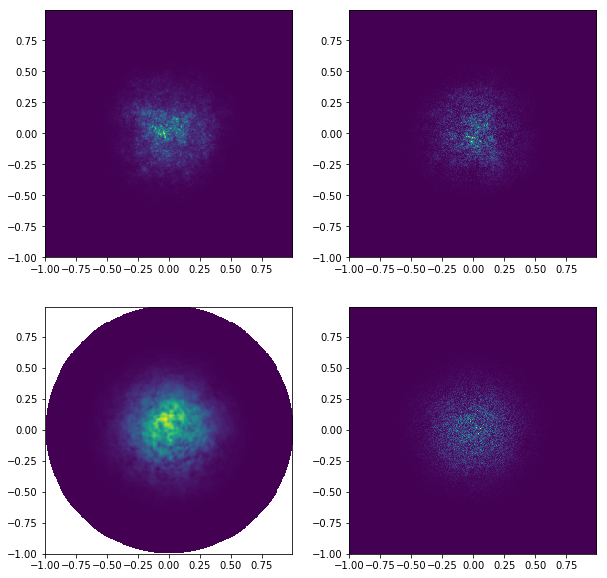

In [20]:
fig, ax = plt.subplots(2,2, figsize=(10,10))

lmin = psf_pure.spatial_dist.lgrid[0].min().value
lmax = psf_pure.spatial_dist.lgrid[0].max().value

ax[0,0].imshow(psf_pure.visible_sky()[0,:,:].T, 
             extent=(lmin,lmax,lmin,lmax), 
             origin='lower')

ax[0,1].imshow(psf_poiss.visible_sky()[0,:,:].T, 
             extent=(lmin,lmax,lmin,lmax), 
             origin='lower')

ax[1,0].imshow(psf_pure_sph.visible_sky()[0,:,:].T, 
             extent=(lmin,lmax,lmin,lmax), 
             origin='lower')

ax[1,1].imshow(psf_poiss_sph.visible_sky()[0,:,:].T, 
             extent=(lmin,lmax,lmin,lmax), 
             origin='lower')

plt.show()

### Visibilities

We can also determine the visibilities over a uniform grid:

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in power
/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in power


NameError: name 'psf_poiss_direct' is not defined

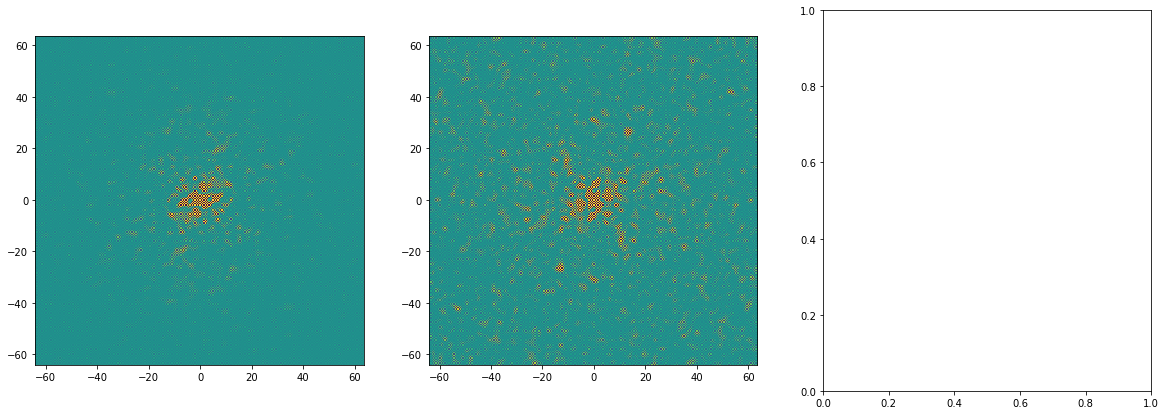

In [16]:
fig, ax = plt.subplots(1,3, figsize=(20,7))

umin = psf_pure.ugrid_raw0.min().value
umax = psf_pure.ugrid_raw0.max().value

ax[0].imshow(np.real(psf_pure.visibility[0,:,:].value),
             extent=(umin,umax,umin,umax), 
             origin='lower',vmin=-100., vmax = 100.)

ax[1].imshow(np.real(psf_poiss.visibility[0,:,:].value), 
             extent=(umin,umax,umin,umax), 
             origin='lower',vmin=-100., vmax = 100.)

# This takes quite a while because of the size of u0.
ax[2].imshow(np.real(psf_poiss_direct.visibility[0].reshape((N_u,N_u))), 
             extent=(umin,umax,umin,umax), 
             origin='lower',vmin=-100., vmax = 100.)

plt.show()

More usefully, we can determine circularly averaged quantities, such as the circularly averaged square visibility:

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in power
/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/spore/mock/foregrounds.py:145: ComplexWarning: Casting complex values to real discards the imaginary part
  vis2[i, j + i] = self._circavg(v2)
/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/spore/mock/foregrounds.py:146: ComplexWarning: Casting complex values to real discards the imaginary part
  vis2[j + i, i] = self._circavg(v2)
/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in power


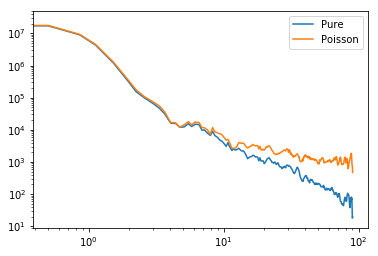

In [17]:
plt.plot(psf_pure.ugrid, psf_pure.visibility_squared_circular[0,0,:],    # Note the first two dimensions refer to frequency -- we just use nu0
         label="Pure") 
plt.plot(psf_poiss.ugrid, psf_poiss.visibility_squared_circular[0,0,:],
         label="Poisson")

plt.legend()
plt.xscale('log')
plt.yscale('log')

You can see the smallest scales have a significant shot-noise contribution.

### Covariance of Visibilities

Because it is such an important quantity, we also provide a function for generating the covariance of visibilities as a function of scale $u$. One can use it like this:

In [18]:
from spore.mock.utils import visibility_covariance

Basically, to the function we just pass a number of iterations, and then the arguments we would usually pass to the ``PointSourceForegrounds`` constructor. 
One thing to be careful of is *not* to set a seed in the spatial distribution -- otherwise each iteration will have the same realisation!

In [24]:
# Ensure seed is None
poisson_sky.seed = None

ubins, cov = visibility_covariance(
    niter= 50,  # Number of iterations from which to estimate covariance
    beam_model=gaussbeam,
    source_counts=pl_source_counts,
    spec_index_model = spec_index_dist,
    spatial_dist = poisson_sky
)

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in power


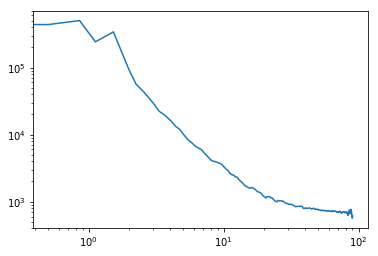

In [25]:
plt.plot(ubins, cov)
plt.xscale('log')
plt.yscale("log")

## All-Component Mock

In [19]:
from spore.mock.foregrounds import GalacticForegrounds, ThermalForegrounds, Foregrounds

In [20]:
gal_sky = spatial_dist.PureClustering_FlatSky(f0 = 1., # Frequencies (as ratios to ref. freq.) to evaluate sky at.
                                              sky_size = 2.0,             # Size of sky in l,m co-ordinates
                                              ncells = 256,              # Number of grid cells along a side 
                                              seed = 4321,                # Optional seed to enforce the same realisation on every run
                                              power_spectrum = lambda u : 0.01 * (u/0.1)**-2.7,   # A function defining an isotropic power spectrum of sources as a function of scale u.
                                              use_lognormal=False
                                             )

gal_spec_index = spectral_index.UniversalDist(0.55)

gal_fg = GalacticForegrounds(fluctation_temp=253 * 0.8, Aeff=20.,
                             beam_model=gaussbeam,
                             spec_index_model = gal_spec_index,
                             spatial_dist = gal_sky
                             )

In [21]:
th_fg = ThermalForegrounds(Aeff=20., Tsys=100, deltaT = 1000., dnu=1e5)

In [22]:
fg = Foregrounds(beam_model=gaussbeam,
                 galactic_kwargs = dict(fluctation_temp=253*0.8,
                                        Aeff = 20.,
                                        spec_index_model=gal_spec_index,
                                        spatial_dist = gal_sky),
                 point_source_kwargs = dict(spec_index_model=spec_index_dist,
                                            spatial_dist = poisson_sky,
                                            source_counts = pl_source_counts))

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in power
/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in power


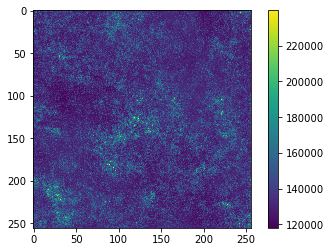

In [24]:
plt.imshow(fg.sky[0])
plt.colorbar()

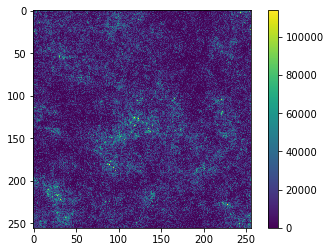

In [25]:
plt.imshow(fg.point_source_foregrounds.sky[0])
plt.colorbar()

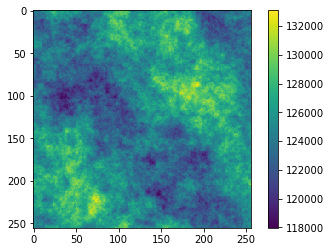

In [26]:
plt.imshow(fg.galactic_foregrounds.sky[0])
plt.colorbar()

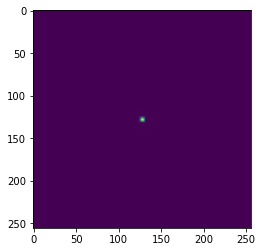

In [27]:
plt.imshow(np.abs(fg.visibility[0]))

In [23]:
poisson_sky.seed=None
gal_sky.seed=None
th_fg.seed = None

u, cov_full = visibility_covariance(foreground_model=Foregrounds,
                                    niter=100,
                                    beam_model=gaussbeam,
                                    galactic_kwargs = dict(
                                        fluctation_temp=253*0.8,
                                        Aeff = 20.,
                                        spec_index_model=gal_spec_index,
                                        spatial_dist = gal_sky),
                                    point_source_kwargs = dict(
                                        spec_index_model=spec_index_dist,
                                        spatial_dist = poisson_sky,
                                        source_counts = pl_source_counts))

u, cov_gal = visibility_covariance(foreground_model=GalacticForegrounds,
                                    niter=100,
                                    beam_model=gaussbeam,
                                    fluctation_temp=253*0.8,
                                    Aeff = 20.,
                                    spec_index_model=gal_spec_index,
                                    spatial_dist = gal_sky)

u, cov_ps = visibility_covariance(foreground_model=PointSourceForegrounds,
                                  niter=100,
                                  beam_model=gaussbeam,
                                  spec_index_model=spec_index_dist,
                                  spatial_dist = poisson_sky,
                                  source_counts = pl_source_counts)


/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in power
/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in power


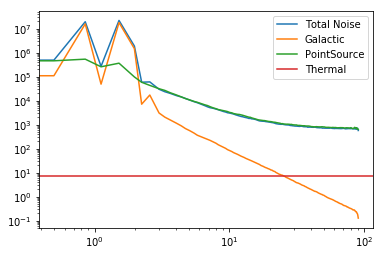

In [25]:
plt.plot(u,cov_full, label="Total Noise")
plt.plot(u,cov_gal, label='Galactic')
plt.plot(u,cov_ps, label="PointSource")

plt.axhline(2*th_fg.sigma**4, label='Thermal', color="C3")

plt.xscale('log')
plt.yscale('log')
plt.legend()

### Using PyGSM to calculate the Galactic model

In [23]:
from spore.model.spatial_dist import GSM

In [24]:
gsm_sky = GSM(f0 = 1., # Frequencies (as ratios to ref. freq.) to evaluate sky at.
              sky_size = 2.0,             # Size of sky in l,m co-ordinates
              ncells = 256,              # Number of grid cells along a side 
              theta0=np.pi/2)

In [25]:
gal_fg = GalacticForegrounds(fluctation_temp=253 * 0.8, Aeff=20., # For GSM, these are not used...
                             beam_model=gaussbeam,
                             spec_index_model = gal_spec_index,
                             spatial_dist = gsm_sky
                             )

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/spore/model/spatial_dist.py:235: RuntimeWarning: invalid value encountered in divide
  phimod = np.arccos(L.flatten()[mask] / lm[mask])


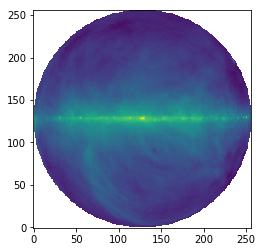

In [31]:
plt.imshow(np.log(gal_fg.sky[0].T), origin='lower')

In [26]:
fg = Foregrounds(beam_model=gaussbeam,
                 galactic_kwargs = dict(fluctation_temp=253*0.8,
                                        Aeff = 20.,
                                        spec_index_model=gal_spec_index,
                                        spatial_dist = gsm_sky),
                 point_source_kwargs = dict(spec_index_model=spec_index_dist,
                                            spatial_dist = poisson_sky_sph,
                                            source_counts = pl_source_counts))

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/healpy/sphtfunc.py:292: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


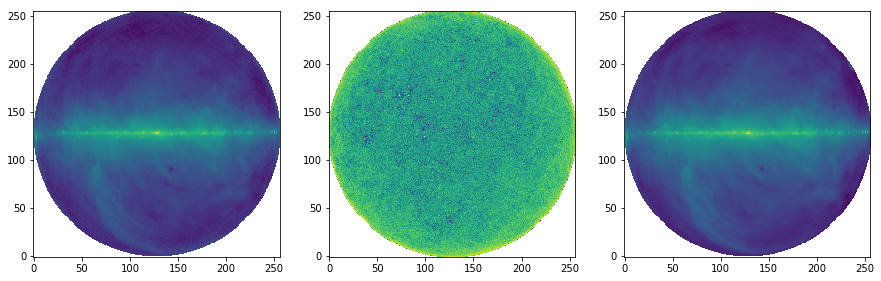

In [33]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(np.log(fg.sky[0].T), origin='lower')
ax[1].imshow(np.log(fg.point_source_foregrounds.sky[0].T), origin='lower')
ax[2].imshow(np.log(fg.galactic_foregrounds.sky[0].T), origin='lower')

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log


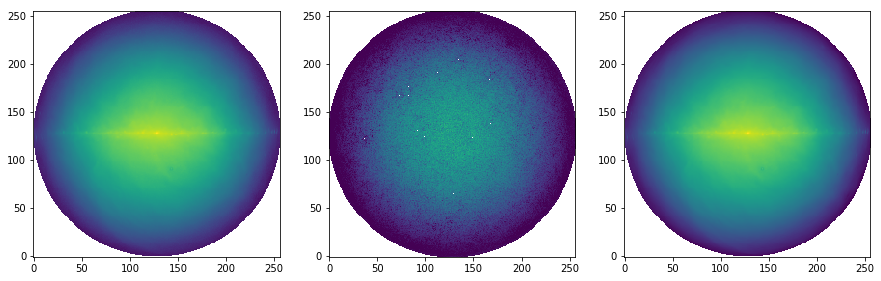

In [29]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
vmin = np.nanmin(np.log(fg.visible_sky()[0]))
vmax = np.nanmax(np.log(fg.visible_sky()[0]))
ax[0].imshow(np.log(fg.visible_sky()[0].T), origin='lower', vmin=vmin, vmax=vmax)
ax[1].imshow(np.log(fg.point_source_foregrounds.visible_sky()[0].T), origin='lower', vmin=vmin, vmax=vmax)
ax[2].imshow(np.log(fg.galactic_foregrounds.visible_sky()[0].T), origin='lower', vmin=vmin, vmax=vmax)

### Generate 2D power spectrum

To generate the 2D power spectrum, we create a foreground object that contains a regular array of frequencies, as we'll need those to form the second dimensions of the 2D power spectrum:

In [27]:
f0 = np.linspace(1,1.6/1.5, 100)    # Gives 100 kHz channels between 150 MHz and 160 MHz

fg = Foregrounds(
    beam_model=beam.CircularGaussian(
        nu0   = 150.,             # The only place the actual reference frequency is defined (in MHz)
        D     = 4.,               # The diameter of a tile (for MWA)
    ),
    galactic_kwargs = dict(
        fluctation_temp=253*0.8,  # Unused
        Aeff = 20.,
        spec_index_model=gal_spec_index,
        spatial_dist = GSM(
            f0       = f0,        # Frequencies (as ratios to ref. freq.) to evaluate sky at.
            sky_size = 2.0,       # Size of sky in l,m co-ordinates
            ncells   = 512,       # Number of grid cells along a side 
            theta0   = 3*np.pi/4.,   # Zenith pointing
            low_res  = True       # Use low-res base maps for speed
        )
    ),
    point_source_kwargs = dict(
        spec_index_model=spec_index_dist,
        spatial_dist = spatial_dist.PoissonClustering_Spherical(
            f0       = f0,
            sky_size = 2.0,       # Must be the same as the Galactic spatial_dist sky_size
            ncells   = 512,       # Must be the same as the Galactic spatial_dist ncells
            seed     = 1234,      # Just so we get the same results every time we run the notebook  
            nside    = 256,       # Resolution of underlying spherical HEALpix grid
            lmax     = 1000,      # Resolution of power spectrum itself
            power_spectrum = lambda l : (l/0.3)**-2.0,
            
        ),
        source_counts = source_counts.PowerLawSourceCounts(
            Smin0    = 1e-2, 
            Smax0    = 1., 
            f0       = f0,
            alpha    = 6998.,     # Normalisation of power-law
            beta     = 1.54       # Slope of power-law
        )
    )
)

We'll first check the simple underlying gridded sky/visibility for all components (we do this at first and last frequencies alternatively to check that all the frequencies "worked"):

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


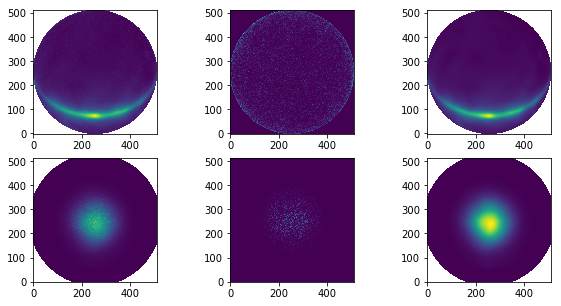

In [40]:
fig, ax = plt.subplots(2,3,figsize=(10,5))

ax[0,0].imshow(fg.sky[0].T, origin='lower')
ax[0,1].imshow(fg.point_source_foregrounds.sky[0].T, origin='lower')
ax[0,2].imshow(fg.galactic_foregrounds.sky[0].T, origin='lower')

ax[1,0].imshow(fg.visible_sky()[-1].T, origin='lower')
ax[1,1].imshow(fg.point_source_foregrounds.visible_sky()[-1].T, origin='lower')
ax[1,2].imshow(fg.galactic_foregrounds.visible_sky()[-1].T, origin='lower')


Check the visibilities:

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/healpy/sphtfunc.py:292: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/spore/model/spatial_dist.py:235: RuntimeWarning: invalid value encountered in divide
  phimod = np.arccos(L.flatten()[mask] / lm[mask])


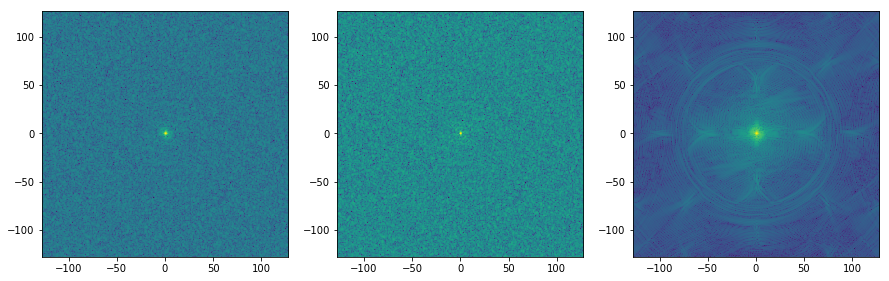

In [29]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

uextent = (fg.ugrid_raw0[0].value, fg.ugrid_raw0[-1].value, fg.ugrid_raw0[0].value, fg.ugrid_raw0[-1].value)

ax[0].imshow(np.abs(fg.visibility[0].T).value, origin='lower', norm=LogNorm(), extent=uextent)
ax[1].imshow(np.abs(fg.point_source_foregrounds.visibility[0].T).value, origin='lower', norm=LogNorm(), extent=uextent)
ax[2].imshow(np.abs(fg.galactic_foregrounds.visibility[0].T).value, origin='lower', norm=LogNorm(), extent=uextent)

Now we can look at the 2D PS of the grid:

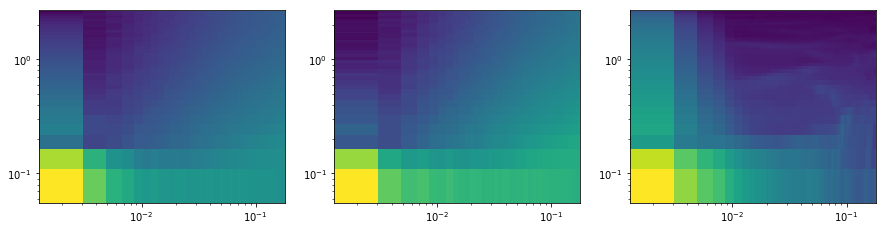

In [30]:
fig, ax = plt.subplots(1,3, figsize=(15,5), subplot_kw={"xscale":'log', 'yscale':'log'})

ps_2d, kperp, ubins = fg.power_spectrum_2d(natural_units=True, taper=np.blackman)
ax[0].imshow(ps_2d.value, extent=(kperp.min().value, kperp.max().value, fg.kpar.min().value, fg.kpar.max().value), 
             origin='lower', norm=LogNorm())

ps_2d, kperp, ubins = fg.point_source_foregrounds.power_spectrum_2d(natural_units=True, taper=np.blackman)
ax[1].imshow(ps_2d.value, extent=(kperp.min().value, kperp.max().value, fg.kpar.min().value, fg.kpar.max().value), 
             origin='lower', norm=LogNorm())

ps_2d, kperp, ubins = fg.galactic_foregrounds.power_spectrum_2d(natural_units=True, taper=np.blackman)
ax[2].imshow(ps_2d.value, extent=(kperp.min().value, kperp.max().value, fg.kpar.min().value, fg.kpar.max().value), 
             origin='lower', norm=LogNorm())


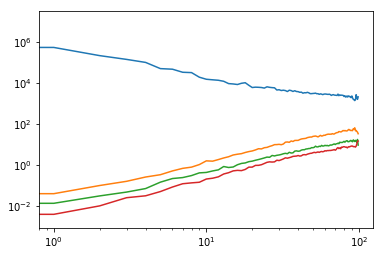

In [47]:
plt.plot(ps_2d[0,:])
plt.plot(ps_2d[10,:])
plt.plot(ps_2d[20,:])
plt.plot(ps_2d[30,:])

plt.xscale('log')
plt.yscale('log')

In [48]:
fg.ugrid_raw0[1]-fg.ugrid_raw0[0]

<Quantity 0.5 1 / rad>

Let's make a FlatSky Poisson foreground model for comparison

In [41]:
ps_fg_flat = PointSourceForegrounds(
        beam_model=fg.beam_model,
        spec_index_model=fg.point_source_foregrounds.spec_index_model,
        source_counts = fg.point_source_foregrounds.source_counts,
        spatial_dist = spatial_dist.PoissonClustering_FlatSky(
            f0       = f0,
            sky_size = 2.0,       
            ncells   = 512,       
            seed     = 4321,
            power_spectrum = lambda l : (l/0.3)**-2.0,
        )
)

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in power


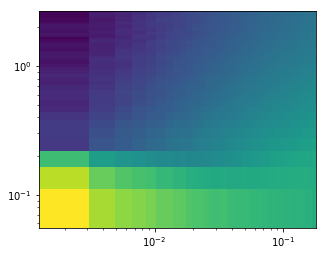

In [42]:
from scipy.signal import blackmanharris

ps_2d, kperp, ubins = ps_fg_flat.power_spectrum_2d(natural_units=True, taper=blackmanharris)
plt.imshow(ps_2d.value, extent=(kperp.min().value, kperp.max().value, fg.kpar.min().value, fg.kpar.max().value), 
             origin='lower', norm=LogNorm())
plt.xscale('log')
plt.yscale('log')

In [80]:
from powerbox.dft import fft

In [96]:
from spore.measure.ps_2d_from_single_vis import ps_3d_to_ps_2d

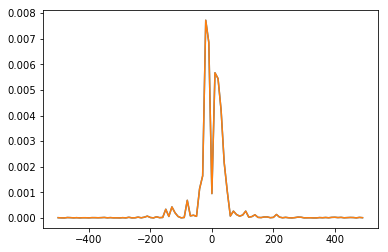

In [91]:
ft3d,eta = fft(fg.visibility.value, L=0.1, a=0, b = 2*np.pi, axes=(0,))
ft,eta = fft(fg.visibility[:,100,50], L=0.1, a=0, b = 2*np.pi)

plt.plot(eta[0],np.abs(ft3d[:,100,50])**2)
plt.plot(eta[0],np.abs(ft)**2)


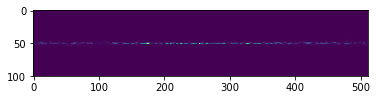

In [95]:
plt.imshow(np.abs(ft3d[:,200,:])**2)

Now import the positions of the tiles (for the MWA) and convert them to physical baselines:

In [98]:
ps_2d, ubins = ps_3d_to_ps_2d(np.abs(ft3d)**2, fg.ugrid_raw0, fg.nu)

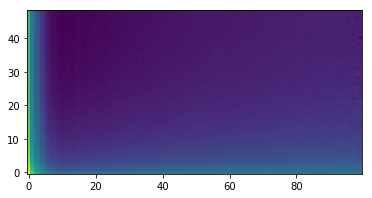

In [108]:
plt.imshow(ps_2d[51:], origin='lower',norm=LogNorm())

In [28]:
from spore.mock.convert_sim_to_vis import pos_to_baselines, baselines_to_u0

pos = np.genfromtxt("../../../clustering_counts_paper/hex_pos.txt")[:,[1,2]]  # MWA tile positions
baselines = pos_to_baselines(pos)

Now we plot the values of $(u,v)$ for the baselines, at the reference frequency of $\nu_0=150$ MHz. We also show a square corresponding to the range of $u,v$ calculated for our simulated grid.

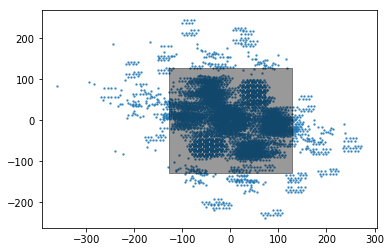

In [54]:
u0 = baselines_to_u0(baselines,150.)
plt.scatter(u0[:,0],u0[:,1], s=2, alpha=0.7)
plt.fill_between(np.array([fg.ugrid_raw0[0].value, fg.ugrid_raw0[-1].value]), fg.ugrid_raw0[0].value, fg.ugrid_raw0[-1].value, color='k', alpha=0.4)

Clearly, many of the baselines are longer than our simulation covers. The code underneath deals with this by just removing these baselines altogether. We could alleviate this by setting the number of cells in our simulation higher.

Here we show how the original number of baselines is reduced, and we interpolate the visibility onto the actual baseline positions:

732 baselines were removed due to being longer than the maximum of 127.5.


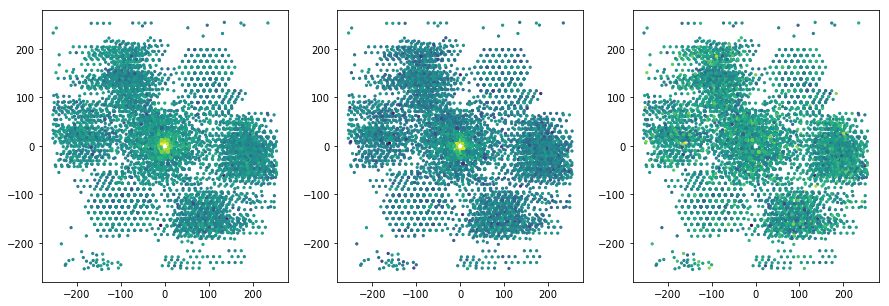

In [47]:
vis, reduced_baselines = fg.visibility_at_baselines(baselines,True)

fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].scatter(reduced_baselines[:,0], reduced_baselines[:,1], c = np.log(np.abs(vis[0])),s=5)
ax[1].scatter(reduced_baselines[:,0], reduced_baselines[:,1], c = np.log(np.abs(vis[-1])),s=5)
ax[2].scatter(reduced_baselines[:,0], reduced_baselines[:,1], c = np.log(np.abs(vis[0])/np.abs(vis[-1])),s=5)

The next step is to re-grid the visibilities back onto a regular grid:

732 baselines were removed due to being longer than the maximum of 127.5.
732 baselines were removed due to being longer than the maximum of 127.5.
732 baselines were removed due to being longer than the maximum of 127.5.


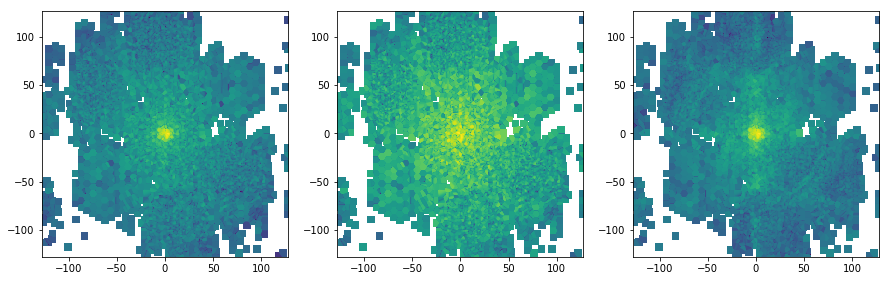

In [55]:
fig, ax = plt.subplots(1,3, figsize=(15,5))

gridded_vis = fg.regrid_visibilities(baselines, beam_radius = 5.)
ax[0].imshow(np.abs(gridded_vis)[:,:,0].T,origin='lower', norm=LogNorm(), extent=uextent)


gridded_vis = fg.point_source_foregrounds.regrid_visibilities(baselines, beam_radius = 5.)
ax[1].imshow(np.abs(gridded_vis)[:,:,0].T,origin='lower', norm=LogNorm(), extent=uextent)


gridded_vis = fg.galactic_foregrounds.regrid_visibilities(baselines, beam_radius = 5.)
ax[2].imshow(np.abs(gridded_vis)[:,:,0].T,origin='lower', norm=LogNorm(), extent=uextent)

Finally, we want to FT the frequency axis, and cylindrically average in the $(u,v)$-plane to get the 2D Power:

732 baselines were removed due to being longer than the maximum of 127.5.
0 1.41421356237 0.99609375 0.99609375 nan
1 1.41326187088 0.995423431191 0.995423431191 nan
2 1.4123114594 0.994754013954 0.994754013954 nan
3 1.41136232535 0.994085496472 0.994085496472 nan
4 1.41041446617 0.993417876931 0.993417876931 nan
5 1.40946787928 0.992751153524 0.992751153524 nan
6 1.40852256212 0.992085324447 0.992085324447 nan
7 1.40757851215 0.991420387902 0.991420387902 nan
8 1.40663572681 0.990756342096 0.990756342096 nan
9 1.40569420356 0.990093185241 0.990093185241 nan
10 1.40475393988 0.989430915552 0.989430915552 nan
11 1.40381493324 0.98876953125 0.98876953125 nan
12 1.40287718111 0.988109030561 0.988109030561 nan
13 1.40194068099 0.987449411716 0.987449411716 nan
14 1.40100543037 0.986790672949 0.986790672949 nan
15 1.40007142675 0.9861328125 0.9861328125 nan
16 1.39913866764 0.985475828614 0.985475828614 nan
17 1.39820715055 0.984819719541 0.984819719541 nan
18 1.397276873 0.984164483533 0.9

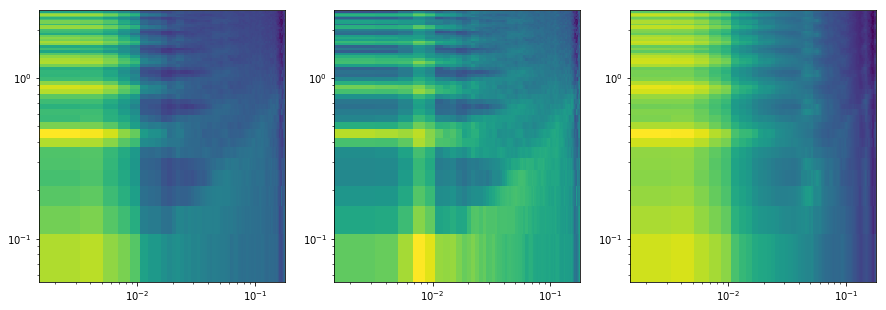

In [32]:
fig, ax = plt.subplots(1,3, figsize=(15,5), subplot_kw={"yscale":'log','xscale':'log'})

ps, kperp, kpar, u = fg.get_2d_power_spectrum(baselines, taper = None, beam_radius=5.)
ax[0].imshow(np.log10(ps.value).T, origin='lower', extent=(kperp.min().value,kperp.max().value,kpar.min().value, kpar.max().value), aspect='auto')

ps, kperp, kpar, u = fg.point_source_foregrounds.get_2d_power_spectrum(baselines, taper = None, beam_radius=5.)
ax[1].imshow(np.log10(ps.value).T, origin='lower', extent=(kperp.min().value,kperp.max().value,kpar.min().value, kpar.max().value), aspect='auto')

ps, kperp, kpar, u = fg.galactic_foregrounds.get_2d_power_spectrum(baselines, taper = None, beam_radius=5.)
ax[2].imshow(np.log10(ps.value).T, origin='lower', extent=(kperp.min().value,kperp.max().value,kpar.min().value, kpar.max().value), aspect='auto')


732 baselines were removed due to being longer than the maximum of 127.5.
732 baselines were removed due to being longer than the maximum of 127.5.
732 baselines were removed due to being longer than the maximum of 127.5.


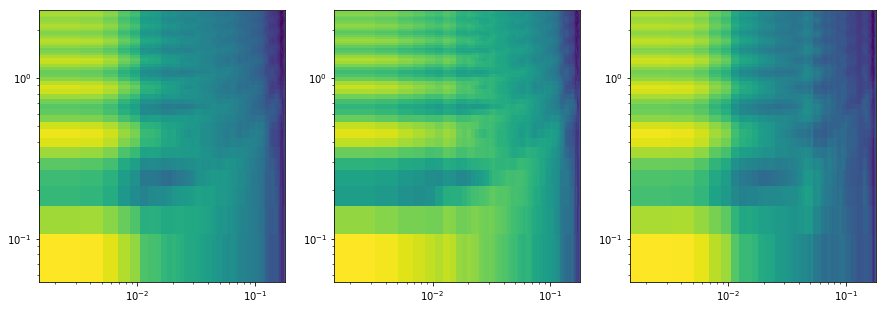

In [57]:
fig, ax = plt.subplots(1,3, figsize=(15,5), subplot_kw={"yscale":'log','xscale':'log'})

ps, kperp, kpar, u = fg.get_2d_power_spectrum(baselines, taper = np.blackman, beam_radius=5.)
ax[0].imshow(np.log10(ps.value).T, origin='lower', extent=(kperp.min().value,kperp.max().value,kpar.min().value, kpar.max().value), aspect='auto')

ps, kperp, kpar, u = fg.point_source_foregrounds.get_2d_power_spectrum(baselines, taper = np.blackman, beam_radius=5.)
ax[1].imshow(np.log10(ps.value).T, origin='lower', extent=(kperp.min().value,kperp.max().value,kpar.min().value, kpar.max().value), aspect='auto')

ps, kperp, kpar, u = fg.galactic_foregrounds.get_2d_power_spectrum(baselines, taper = np.blackman, beam_radius=5.)
ax[2].imshow(np.log10(ps.value).T, origin='lower', extent=(kperp.min().value,kperp.max().value,kpar.min().value, kpar.max().value), aspect='auto')


In [39]:
%timeit fg.galactic_foregrounds.spatial_dist.healpix_brightness(1)

1 loop, best of 3: 243 ms per loop


In [63]:
%%timeit 

pos = fg.spatial_dist.source_positions(fg.point_source_foregrounds.source_counts.total_number_density.value)
n = len(pos[0])
fg.point_source_foregrounds.spatial_dist.sky(pos,
                    fg.point_source_foregrounds.source_counts.sample_source_counts(n),
                    fg.point_source_foregrounds.spec_index_model.sample(n))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
1 loop, best of 3: 10.1 s per loop


Below just checks the difference between Poisson/Pure spherical clustering

In [29]:
fg_pure = Foregrounds(
    beam_model=beam.CircularGaussian(
        nu0   = 150.,             # The only place the actual reference frequency is defined (in MHz)
        D     = 4.,               # The diameter of a tile (for MWA)
    ),
    galactic_kwargs = dict(
        fluctation_temp=253*0.8,  # Unused
        Aeff = 20.,
        spec_index_model=gal_spec_index,
        spatial_dist = GSM(
            f0       = f0,        # Frequencies (as ratios to ref. freq.) to evaluate sky at.
            sky_size = 2.0,       # Size of sky in l,m co-ordinates
            ncells   = 512,       # Number of grid cells along a side 
            theta0   = 3*np.pi/4.,   # Zenith pointing
            low_res  = True       # Use low-res base maps for speed
        )
    ),
    point_source_kwargs = dict(
        spec_index_model=spec_index_dist,
        spatial_dist = spatial_dist.PureClustering_Spherical(
            f0       = f0,
            sky_size = 2.0,       # Must be the same as the Galactic spatial_dist sky_size
            ncells   = 512,       # Must be the same as the Galactic spatial_dist ncells
            seed     = 1234,      # Just so we get the same results every time we run the notebook  
            nside    = 256,       # Resolution of underlying spherical HEALpix grid
            lmax     = 1000,      # Resolution of power spectrum itself
            power_spectrum = lambda l : (l/0.3)**-2.0,
            
        ),
        source_counts = source_counts.PowerLawSourceCounts(
            Smin0    = 1e-3, 
            Smax0    = 0.03, 
            f0       = f0,
            alpha    = 6998.,     # Normalisation of power-law
            beta     = 1.54       # Slope of power-law
        )
    )
)

/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/healpy/sphtfunc.py:292: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/home/steven/anaconda2/envs/spore/lib/python2.7/site-packages/spore/model/spatial_dist.py:235: RuntimeWarning: invalid value encountered in divide
  phimod = np.arccos(L.flatten()[mask] / lm[mask])


0 1.41421356237 0.99609375 0.99609375 nan
1 1.41326187088 0.995423431191 0.995423431191 nan
2 1.4123114594 0.994754013954 0.994754013954 nan
3 1.41136232535 0.994085496472 0.994085496472 nan
4 1.41041446617 0.993417876931 0.993417876931 nan
5 1.40946787928 0.992751153524 0.992751153524 nan
6 1.40852256212 0.992085324447 0.992085324447 nan
7 1.40757851215 0.991420387902 0.991420387902 nan
8 1.40663572681 0.990756342096 0.990756342096 nan
9 1.40569420356 0.990093185241 0.990093185241 nan
10 1.40475393988 0.989430915552 0.989430915552 nan
11 1.40381493324 0.98876953125 0.98876953125 nan
12 1.40287718111 0.988109030561 0.988109030561 nan
13 1.40194068099 0.987449411716 0.987449411716 nan
14 1.40100543037 0.986790672949 0.986790672949 nan
15 1.40007142675 0.9861328125 0.9861328125 nan
16 1.39913866764 0.985475828614 0.985475828614 nan
17 1.39820715055 0.984819719541 0.984819719541 nan
18 1.397276873 0.984164483533 0.984164483533 nan
19 1.39634783253 0.98351011885 0.98351011885 nan
20 1.3954

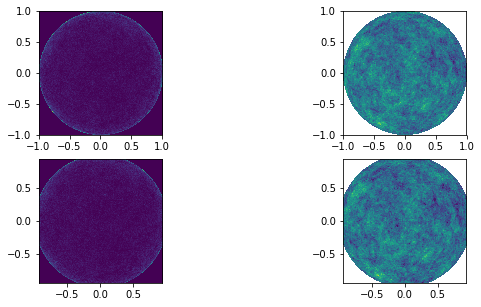

In [30]:
fig, ax = plt.subplots(2,2,figsize=(10,5))

lg = np.array(fg.spatial_dist.lgrid)#.value
lgp = np.array(fg_pure.spatial_dist.lgrid)#.value

ax[0,0].imshow(fg.point_source_foregrounds.sky[0].T, origin='lower', extent = (lg[0][0],lg[0][-1],lg[0][0],lg[0][-1]))
ax[0,1].imshow(fg_pure.point_source_foregrounds.sky[0].T, origin='lower', extent = (lgp[0][0],lgp[0][-1],lgp[0][0],lgp[0][-1]))

ax[1,0].imshow(fg.point_source_foregrounds.sky[-1].T, origin='lower', extent = (lg[-1][0],lg[-1][-1],lg[-1][0],lg[-1][-1]))
ax[1,1].imshow(fg_pure.point_source_foregrounds.sky[-1].T, origin='lower', extent = (lgp[-1][0],lgp[-1][-1],lgp[-1][0],lgp[-1][-1]))

In [31]:
np.nanmin(fg_pure.point_source_foregrounds.sky[-1]- fg_pure.point_source_foregrounds.sky[0])

-3594.4001976593927

In [60]:
fg.visibility
fg_pure.visibility

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


<Quantity [[[-0.05217924+0.j        , 0.04960605-0.00667515j,
             -0.04359559+0.01334621j,...,  0.02942690+0.01675551j,
             -0.04359559-0.01334621j, 0.04960605+0.00667515j],
            [ 0.04924692+0.00471323j,-0.04331601-0.00269566j,
              0.03140055-0.00129996j,..., -0.03268142-0.02062727j,
              0.04386952+0.0187798j ,-0.04833064-0.01052818j],
            [-0.03939695-0.01982607j, 0.03298213+0.02262701j,
             -0.01816000-0.01845013j,...,  0.02441883+0.02172163j,
             -0.03200179-0.0225568j , 0.03759622+0.0192861j ],
            ..., 
            [ 0.02215255-0.04109424j,-0.02036113+0.03346202j,
              0.01669338-0.02695282j,..., -0.00393359+0.01865535j,
              0.01365649-0.0394565j ,-0.02114156+0.04565533j],
            [-0.03939695+0.01982607j, 0.03759622-0.0192861j ,
             -0.03200179+0.0225568j ,...,  0.00202824-0.0037386j ,
             -0.01816000+0.01845013j, 0.03298213-0.02262701j],
            [ 0.049246

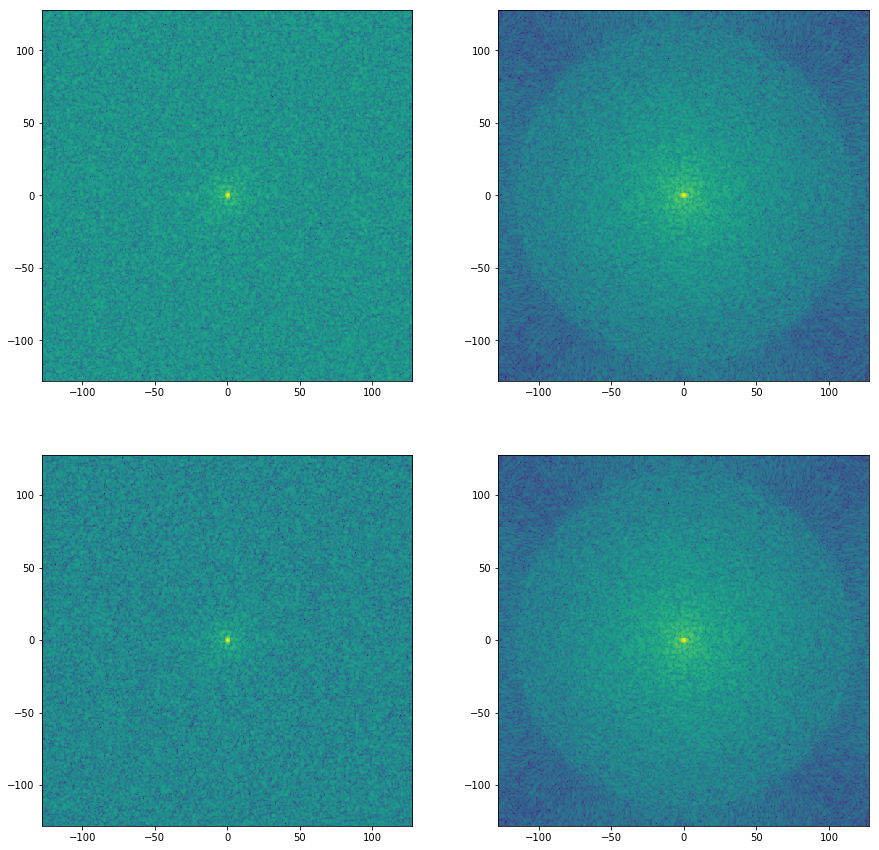

In [65]:
fig, ax = plt.subplots(2,2,figsize=(15,15))

uextent = (fg.ugrid_raw0[0].value, fg.ugrid_raw0[-1].value, fg.ugrid_raw0[0].value, fg.ugrid_raw0[-1].value)

ax[0,0].imshow(np.abs(fg.point_source_foregrounds.visibility[0].T).value, origin='lower', norm=LogNorm(), extent=uextent)
ax[0,1].imshow(np.abs(fg_pure.point_source_foregrounds.visibility[0].T).value, origin='lower', norm=LogNorm(), extent=uextent)

ax[1,0].imshow(np.abs(fg.point_source_foregrounds.visibility[-1].T).value, origin='lower', norm=LogNorm(), extent=uextent)
ax[1,1].imshow(np.abs(fg_pure.point_source_foregrounds.visibility[-1].T).value, origin='lower', norm=LogNorm(), extent=uextent)

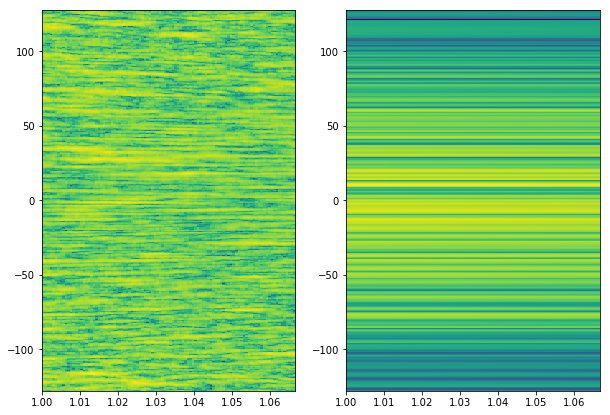

In [70]:
fig, ax = plt.subplots(1,2,figsize=(10,7))

extent = (f0[0],f0[-1], fg.ugrid_raw0[0].value, fg.ugrid_raw0[-1].value)

ax[0].imshow(np.abs(fg.point_source_foregrounds.visibility[:,128,:].T).value, origin='lower', norm=LogNorm(), extent=extent, aspect='auto')
ax[1].imshow(np.abs(fg_pure.point_source_foregrounds.visibility[:,128,:].T).value, origin='lower', norm=LogNorm(), extent=extent, aspect='auto')

In [30]:
gsm.map_ni

array([[ 0.01288 ,  0.01236 ,  0.01291 , ...,  0.01224 ,  0.0122  ,
         0.01251 ],
       [-0.006761, -0.006404, -0.006622, ..., -0.01404 , -0.01406 ,
        -0.01338 ],
       [ 0.004089,  0.004047,  0.003966, ...,  0.004976,  0.005029,
         0.005076],
       [ 0.01551 ,  0.01409 ,  0.01454 , ...,  0.01966 ,  0.02085 ,
         0.02174 ],
       [ 0.02301 ,  0.02079 ,  0.02187 , ...,  0.02398 ,  0.02539 ,
         0.02655 ],
       [ 0.01672 ,  0.01516 ,  0.01559 , ...,  0.02098 ,  0.02194 ,
         0.02296 ]])

In [56]:
l = np.random.uniform(high=5.0, size=10000000)
m = np.random.uniform(high=5.0, size=10000000)
l2 = l**2 + m**2

In [59]:
np.mean(np.exp(-l2)*np.exp(-2j*np.pi*l*0.01))

(0.031446438042907275-0.0011144351551546031j)